In [ ]:
# Read image
image_path = '../input/computer-vision-resources/car_illus.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image, channels=1)
image = tf.image.resize(image, size=[400, 400])

# Embossing kernel
kernel = tf.constant([
    [-2, -1, 0],
    [-1, 1, 1],
    [0, 1, 2],
])

# Reformat for batch compatibility.
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)

image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    strides=1,
    padding='VALID',
)

image_detect = tf.nn.relu(image_filter)

# Show what we have so far
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.title('Input')
plt.subplot(132)
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.title('Filter')
plt.subplot(133)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title('Detect')
plt.show();

## Apply Pooling to condense

In [ ]:
image_condense = tf.nn.pool(
    input=image_detect,
    window_shape=(2, 2),
    pooling_type='MAX',
    strides=(2, 2),
    padding='SAME',
)

In [ ]:
plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title("Detect (ReLU)")
plt.subplot(122)
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.title("Condense (MaxPool)")
plt.show();

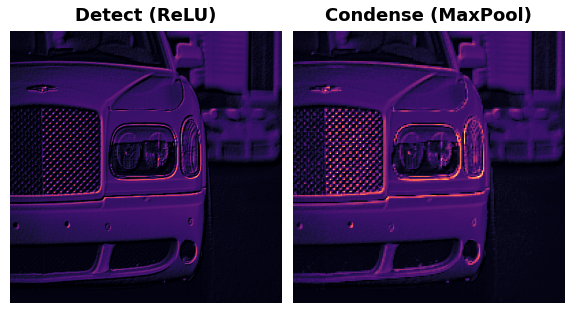

In [ ]:
REPEATS = 4
SIZE = [64, 64]

# Create a randomly shifted circle
image = visiontools.circle(SIZE, r_shrink=4, val=1)
image = tf.expand_dims(image, axis=-1)
image = visiontools.random_transform(image, jitter=3, fill_method='replicate')
image = tf.squeeze(image)

plt.figure(figsize=(16, 4))
plt.subplot(1, REPEATS+1, 1)
plt.imshow(image, vmin=0, vmax=1)
plt.title("Original\nShape: {}x{}".format(image.shape[0], image.shape[1]))
plt.axis('off')

# Now condense with maximum pooling several times
for i in range(REPEATS):
    ax = plt.subplot(1, REPEATS+1, i+2)
    image = tf.reshape(image, [1, *image.shape, 1])
    image = tf.nn.pool(image, window_shape=(2,2), strides=(2, 2), padding='SAME', pooling_type='MAX')
    image = tf.squeeze(image)
    plt.imshow(image, vmin=0, vmax=1)
    plt.title("MaxPool {}\nShape: {}x{}".format(i+1, image.shape[0], image.shape[1]))
    plt.axis('off')

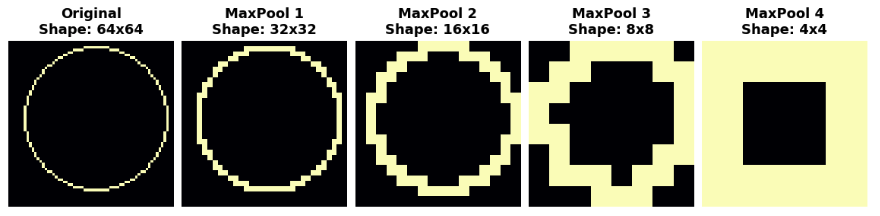

## Global Average Pooling

In [ ]:
feature_maps = [visiontools.random_map([5, 5], scale=0.1, decay_power=4) for _ in range(8)]

gs = gridspec.GridSpec(1, 8, wspace=0.01, hspace=0.01)
plt.figure(figsize=(18, 2))
for i, feature_map in enumerate(feature_maps):
    plt.subplot(gs[i])
    plt.imshow(feature_map, vmin=0, vmax=1)
    plt.axis('off')
plt.suptitle('Feature Maps', size=18, weight='bold', y=1.1)
plt.show()

# reformat for TensorFlow
feature_maps_tf = [tf.reshape(feature_map, [1, *feature_map.shape, 1])
                   for feature_map in feature_maps]

global_avg_pool = tf.keras.layers.GlobalAvgPool2D()
pooled_maps = [global_avg_pool(feature_map) for feature_map in feature_maps_tf]
img = np.array(pooled_maps)[:,:,0].T

plt.imshow(img, vmin=0, vmax=1)
plt.axis('off')
plt.title('Pooled Feature Maps')
plt.show();

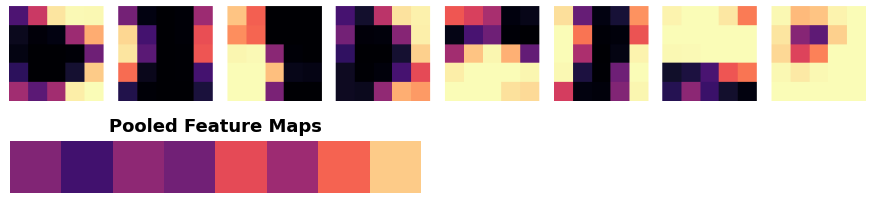

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load VGG16
pretrained_base = tf.keras.models.load_model(
    '../input/cv-course-models/cv-course-models/vgg16-pretrained-base',
)

model = keras.Sequential([
    pretrained_base,
    # Attach a global average pooling layer after the base
    layers.GlobalAvgPool2D(),
])

# Load dataset
ds = image_dataset_from_directory(
    '../input/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=1,
    shuffle=True,
)

ds_iter = iter(ds)

In [ ]:
car = next(ds_iter)

car_tf = tf.image.resize(car[0], size=[128, 128])
car_features = model(car_tf)
car_features = tf.reshape(car_features, shape=(16, 32))
label = int(tf.squeeze(car[1]).numpy())

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(tf.squeeze(car[0]))
plt.axis('off')
plt.title(["Car", "Truck"][label])
plt.subplot(122)
plt.imshow(car_features)
plt.title('Pooled Feature Maps')
plt.axis('off')
plt.show();

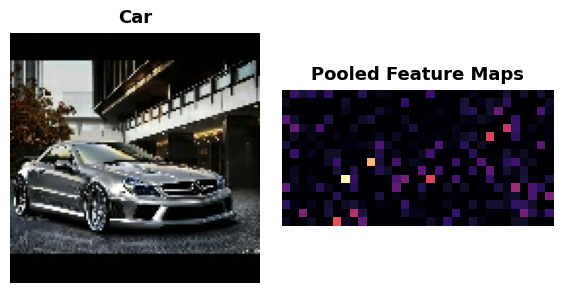